Sina Beyrami

Mohamad Amin Karami

Mahyar Afshar

**Importing libraries**

In [ ]:
import heapq
from typing import List, Optional, Dict
import numpy as np
import matplotlib.pyplot as plt
import copy
import cupy as cp
from tqdm import trange

**Constants and Hyperparameters**

In [ ]:
MAX_HYPER_PERIOD = 1000
TASK_NUMBERS = 100
LAMBDA_PARAM = 0.1
W = 0.6
C1 = 1.4
C2 = 1.4
SWARM_SIZE = 100
ITERATIONS = 250

**Job** and **Task** class

In [ ]:
class Job:
    def __init__(self, id: str, task: "Task", release_time):
        self.id = id
        self.task = task
        self.release_time = release_time
        self.deadline = self.release_time + self.task.period
        self.remaining_execution_time = self.task.execution_time

        self.start_time: Optional[int] = None

    def __lt__(self, other):
        return (self.deadline, self.task.priority, self.id) < (
            other.deadline,
            other.task.priority,
            other.id,
        )

    def __str__(self) -> str:
        return f"Job:(id={self.id}, task={self.task.id}, release_time={self.release_time}, deadline={self.deadline}, priority={self.task.priority}, start_time={self.start_time})"

    def __repr__(self):
        return self.__str__()


class Task:
    def __init__(self, id: int, utilization, period, priority, power) -> None:
        self.id = id
        self.job_id = 1
        self.utilization = utilization
        self.period = period
        self.priority = priority
        self.execution_time = np.round(utilization * period)
        self.power = power

        self.jobs: List[Job] = []

    def create_job_instance(self, release_time):
        job_id = str(self.id) + "_" + str(self.job_id)
        self.job_id += 1
        job = Job(id=job_id, task=self, release_time=release_time)
        self.jobs.append(job)

        return job

    def __str__(self) -> str:
        return f"Task(id={self.id}, utilization={self.utilization}, period={self.period}, priority={self.priority}, power={self.power}), # execution_time={self.execution_time}"

    def __repr__(self):
        return self.__str__()

Report of scheduling

In [ ]:
class ScheduleReport:
    def __init__(self, job: Job, core_id, start_time, end_time, frequency_factor) -> None:
        self.job = job
        self.core_id = core_id
        self.start_time = start_time
        self.end_time = end_time
        self.frequency_factor = frequency_factor

    def __str__(self):
        return f"Job: {self.job.id}, Task: {self.job.task.id}, Core: {self.core_id}, from: {self.start_time} to: {self.end_time}, frequency factor: {self.frequency_factor}"

    def __repr__(self) -> str:
        return self.__str__()

**Task generating**

In [ ]:
def get_divisors(targeted_lcm):
    divisors = []
    for i in range(20, targeted_lcm + 1):
        if targeted_lcm % i == 0:
            divisors.append(i)
    return divisors


def uunifast(num_tasks, total_util, lcm_target=1200):
    utilizations = []
    sum_u = total_util
    periods = []

    divisors = get_divisors(lcm_target)

    for _ in range(num_tasks):
        period = np.random.choice(divisors)
        periods.append(period)

    if lcm_target not in periods:
        periods[0] = lcm_target

    for i in range(1, num_tasks):
        next_rand = np.random.rand()
        next_util = min(1, sum_u * (1 - next_rand ** (1 / (num_tasks - i))))
        utilizations.append(next_util)
        sum_u -= next_util

    utilizations.append(sum_u)

    return utilizations, periods


def generate_tasks(
    task_number,
    total_utilization,
    priority_range,
    power_range,
    targeted_lcm,
) -> List[Task]:
    utilizations, periods = uunifast(task_number, total_utilization, targeted_lcm)
    tasks = []

    for i in range(task_number):
        tasks.append(
            Task(
                id=i + 1,
                utilization=utilizations[i],
                period=periods[i],
                priority=np.random.uniform(priority_range[0], priority_range[1]),
                power=np.random.randint(power_range[0], power_range[1]) * 50,
            )
        )
    return tasks

**Metrics calculation**

In [ ]:
def calculate_hyper_period(tasks: List[Task]) -> int:
    return np.lcm.reduce([task.period for task in tasks])


def calculate_quality_of_service(
    finished_time_by_job_id: Dict[str, int],
    job_by_id: Dict[str, Job],
    lambda_param: float,
):
    quality_of_service = 0

    for id, job in job_by_id.items():
        delay = max(0, finished_time_by_job_id.get(id, MAX_HYPER_PERIOD) - job.deadline)
        quality_of_service += job.task.priority * np.exp(-lambda_param * delay)

    return quality_of_service


def calculate_energy_consumption(schedule_reports: List[ScheduleReport]):
    total_energy = 0

    for report in schedule_reports:
        total_energy += (
            report.job.task.power
            * (report.frequency_factor**3)
            * (report.end_time - report.start_time)
        )

    return total_energy


def calculate_success_rate(
    finished_time_by_job_id: Dict[str, int],
    job_by_id: Dict[str, Job],
):
    ontime_count = 0
    total_count = 0
    for id, job in job_by_id.items():
        total_count += 1

        finished_time = finished_time_by_job_id.get(id, None)

        if finished_time and finished_time <= job.deadline:
            ontime_count += 1

    return ontime_count / total_count


def get_finished_time_by_job_id(
    schedule_reports: List[ScheduleReport],
) -> Dict[str, int]:
    finished_time: Dict[str, int] = {}
    for report in schedule_reports:
        finished_time[report.job.id] = max(
            report.end_time,
            finished_time.get(report.job.id, 0),
        )
    return finished_time


**WFD** mapping

In [ ]:
def worst_fit_decreasing_task_based(tasks: List[Task], core_numbers):
    sorted_tasks = sorted(tasks, key=lambda t: t.utilization, reverse=True)

    core_to_tasks = [[] for _ in range(core_numbers)]
    core_utilizations = [0] * core_numbers

    for task in sorted_tasks:
        best_core = min(range(core_numbers), key=lambda i: core_utilizations[i])
        core_to_tasks[best_core].append(task)
        core_utilizations[best_core] += task.utilization

    return core_to_tasks

**EDF** scheduling

In [ ]:
def edf_task_based(tasks: List[Task], hyper_period, core_id):
    time = 0
    ready_queue = []

    schedules = []
    all_jobs = []

    previous_job: Optional[Job] = None
    while time < hyper_period:
        for task in tasks:
            if time % task.period == 0:
                job = task.create_job_instance(time)
                all_jobs.append(job)

                heapq.heappush(ready_queue, job)

        if ready_queue:
            current_job: Job = heapq.heappop(ready_queue)
            if current_job.start_time == None:
                current_job.start_time = time

            if previous_job is not None:
                if previous_job.id != current_job.id:
                    s = ScheduleReport(
                        job=previous_job,
                        core_id=core_id,
                        start_time=previous_job.start_time,
                        end_time=time,
                        frequency_factor=1,
                    )
                    schedules.append(s)
                    previous_job.start_time = None
                    current_job.start_time = time

            current_job.remaining_execution_time -= 1

            if current_job.remaining_execution_time > 0:
                heapq.heappush(ready_queue, current_job)
                previous_job = current_job
            else:
                s = ScheduleReport(
                    job=current_job,
                    core_id=core_id,
                    start_time=current_job.start_time,
                    end_time=time + 1,
                    frequency_factor=1,
                )
                previous_job = None
                schedules.append(s)

        time += 1

    return schedules, all_jobs

**PSO** implementation

In [ ]:
def schedule_with_start_time_decisions(core_tasks: List[Task], core_id: int, hyper_period: int, freq_factor: float):
    jobs = []
    for task in core_tasks:
        job_count = hyper_period // task.period
        for k in range(job_count):
            release_time = k * task.period
            decision = task.start_time_decisions[k]
            scheduled_start_time = release_time + decision * (task.period - task.execution_time)
            job = task.create_job_instance(release_time)
            job.scheduled_start_time = scheduled_start_time
            jobs.append(job)
    jobs.sort(key=lambda j: j.scheduled_start_time)
    schedule_reports = []
    current_time = 0
    for job in jobs:
        actual_start_time = max(job.scheduled_start_time, current_time)
        finish_time = actual_start_time + (job.task.execution_time / freq_factor)
        job.actual_start_time = actual_start_time
        job.finish_time = finish_time
        schedule_reports.append(ScheduleReport(job, core_id, actual_start_time, finish_time, freq_factor))
        current_time = finish_time
    return schedule_reports, jobs

def evaluate_particle(position, tasks, core_numbers, hyper_period, lambda_param, baseline_qos, min_freq, total_job_count):
    num_tasks = len(tasks)
    assignments = (np.round(position[:num_tasks])).astype(int) % core_numbers
    freq_factors = position[num_tasks:num_tasks+core_numbers]
    job_decisions = position[num_tasks+core_numbers:]
    tasks_copy = [copy.deepcopy(task) for task in tasks]
    core_to_tasks = [[] for _ in range(core_numbers)]
    for idx, task in enumerate(tasks_copy):
        core = assignments[idx]
        core_to_tasks[core].append(task)

    global_job_index = 0
    for task in tasks_copy:
        job_count = hyper_period // task.period
        task.start_time_decisions = list(job_decisions[global_job_index:global_job_index + job_count])
        global_job_index += job_count

    total_schedules = []
    all_jobs = []
    for core in range(core_numbers):
        tasks_for_core = core_to_tasks[core]
        if len(tasks_for_core) == 0:
            continue
        f = freq_factors[core]
        schedules, core_jobs = schedule_with_start_time_decisions(tasks_for_core, core, hyper_period, f)
        total_schedules.extend(schedules)
        all_jobs.extend(core_jobs)
    jobs_by_id = {job.id: job for job in all_jobs}
    finished_time_by_job_id = get_finished_time_by_job_id(total_schedules)
    qos = calculate_quality_of_service(finished_time_by_job_id, jobs_by_id, lambda_param)
    energy = calculate_energy_consumption(total_schedules)
    success_rate = calculate_success_rate(finished_time_by_job_id, jobs_by_id)
    penalty = 0
    if qos < baseline_qos:
        penalty = (baseline_qos - qos) * 100000
    fitness = energy + penalty
    return fitness, qos, energy, success_rate

def run_pso(tasks, core_numbers, hyper_period, lambda_param, baseline_qos, swarm_size=30, iterations=50):
    num_tasks = len(tasks)
    total_job_count = sum(hyper_period // task.period for task in tasks)
    dim = num_tasks + core_numbers + total_job_count

    min_freq = 0.5
    lb_assign = cp.zeros(num_tasks)
    ub_assign = cp.full(num_tasks, core_numbers - 1)
    lb_freq = cp.full(core_numbers, min_freq)
    ub_freq = cp.ones(core_numbers)
    lb_jobs = cp.zeros(total_job_count)
    ub_jobs = cp.ones(total_job_count)
    lb = cp.concatenate([lb_assign, lb_freq, lb_jobs])
    ub = cp.concatenate([ub_assign, ub_freq, ub_jobs])

    swarm = []
    for i in range(swarm_size):
        pos_assign = cp.random.uniform(lb_assign, ub_assign)
        pos_freq = cp.random.uniform(lb_freq, ub_freq)
        pos_jobs = cp.random.uniform(lb_jobs, ub_jobs)
        pos = cp.concatenate([pos_assign, pos_freq, pos_jobs])
        vel = cp.random.uniform(-1, 1, size=dim)
        swarm.append({
            'position': pos,
            'velocity': vel,
            'best_position': pos.copy(),
            'best_fitness': cp.inf
        })
    global_best = None
    global_best_fitness = cp.inf

    w = W
    c1 = C1
    c2 = C2

    for it in trange(iterations, desc="PSO Progress"):
        for particle in swarm:
            pos_cpu = cp.asnumpy(particle['position'])
            fitness, qos, energy, success_rate = evaluate_particle(pos_cpu, tasks, core_numbers, hyper_period, lambda_param, baseline_qos, min_freq, total_job_count)
            if fitness < float(particle['best_fitness']):
                particle['best_fitness'] = fitness
                particle['best_position'] = particle['position'].copy()
            if fitness < float(global_best_fitness):
                global_best_fitness = fitness
                global_best = particle['position'].copy()

        for particle in swarm:
            r1 = cp.random.rand(dim)
            r2 = cp.random.rand(dim)
            particle['velocity'] = (w * particle['velocity'] +
                                    c1 * r1 * (particle['best_position'] - particle['position']) +
                                    c2 * r2 * (global_best - particle['position']))
            particle['position'] = particle['position'] + particle['velocity']
            particle['position'][:num_tasks] = cp.clip(particle['position'][:num_tasks], lb_assign, ub_assign)
            particle['position'][num_tasks:num_tasks+core_numbers] = cp.clip(particle['position'][num_tasks:num_tasks+core_numbers],
                                                                             lb_freq, ub_freq)
            particle['position'][num_tasks+core_numbers:] = cp.clip(particle['position'][num_tasks+core_numbers:], lb_jobs, ub_jobs)

    best_position_cpu = cp.asnumpy(global_best)
    best_fitness, best_qos, best_energy, best_success_rate = evaluate_particle(best_position_cpu, tasks, core_numbers, hyper_period, lambda_param, baseline_qos, min_freq, total_job_count)
    return best_position_cpu, best_fitness, best_qos, best_energy, best_success_rate


**Run** all

In [ ]:
def run_simulation(
    task_numbers,
    core_numbers,
    utilization_per_core,
    max_hyper_period,
    lambda_param,
):
    tasks = generate_tasks(
        task_number=task_numbers,
        total_utilization=core_numbers * utilization_per_core,
        priority_range=(1, 10),
        power_range=(1, 10),
        targeted_lcm=max_hyper_period,
    )

    for task in tasks:
        if task.utilization > 1:
            print(task.id)

    hyper_period = calculate_hyper_period(tasks)

    core_to_tasks = worst_fit_decreasing_task_based(tasks, core_numbers)

    schedule_reports = []
    jobs = []

    for core, core_tasks in enumerate(core_to_tasks):
        schedules, core_jobs = edf_task_based(core_tasks, hyper_period, core)
        schedule_reports.extend(schedules)
        jobs.extend(core_jobs)

    jobs_by_id = {job.id: job for job in jobs}
    finished_time_by_job_id = get_finished_time_by_job_id(schedule_reports)

    qos = calculate_quality_of_service(
        finished_time_by_job_id, jobs_by_id, lambda_param
    )
    energy = calculate_energy_consumption(schedule_reports)
    success_rate = calculate_success_rate(finished_time_by_job_id, jobs_by_id)

    print(
        "\n\nCore Numbers: ", core_numbers, ", Utilization per Core: ", utilization_per_core
    )

    print("---------------BaseLine-----------------")

    print(
        f"Quality of Service: {int(qos)}",
        "Energy Consumption: ",
        int(energy),
        "Success Rate: ",
        success_rate,
    )

    best_position, best_fitness, best_qos, best_energy, best_success_rate = run_pso(tasks, core_numbers, hyper_period,
                                                                                    lambda_param, qos, SWARM_SIZE, ITERATIONS)
    num_tasks = len(tasks)
    total_job_count = sum(hyper_period // task.period for task in tasks)
    assignments = (np.round(best_position[:num_tasks])).astype(int) % core_numbers
    freq_factors = best_position[num_tasks:num_tasks+core_numbers]
    job_decisions = best_position[num_tasks+core_numbers:]
    print("---------------PSO Results-----------------")

    print(
        f"Quality of Service: {int(best_qos)}",
        "Energy Consumption: ",
        int(best_energy),
        "Success Rate: ",
        best_success_rate,
    )

    global_index = 0
    for task in tasks:
        job_count = hyper_period // task.period
        decisions = job_decisions[global_index:global_index + job_count]
        global_index += job_count

**Final** run:

W = 0.6

C1 = 1.4

C2 = 1.4

Swarm size = 80

Max iteration = 200

In [ ]:
TEST_CASES = [
    (8, 0.25),
    (8, 0.5),
    (8, 0.7),
    (16, 0.25),
    (16, 0.5),
    (16, 0.7),
    (32, 0.25),
    (32, 0.5),
    (32, 0.7),
]

for core_numbers, utilization_per_core in TEST_CASES:
    run_simulation(
        TASK_NUMBERS, core_numbers, utilization_per_core, MAX_HYPER_PERIOD, LAMBDA_PARAM
    )



Core Numbers:  8 , Utilization per Core:  0.25
---------------BaseLine-----------------
Quality of Service: 7823 Energy Consumption:  736250 Success Rate:  1.0


PSO Progress: 100%|██████████| 200/200 [09:09<00:00,  2.75s/it]


---------------PSO Results-----------------
Quality of Service: 7822 Energy Consumption:  494437 Success Rate:  0.9880534082923401


Core Numbers:  8 , Utilization per Core:  0.5
---------------BaseLine-----------------
Quality of Service: 10540 Energy Consumption:  1093250 Success Rate:  1.0


PSO Progress: 100%|██████████| 200/200 [13:09<00:00,  3.95s/it]


---------------PSO Results-----------------
Quality of Service: 10410 Energy Consumption:  974455 Success Rate:  0.9018906489524783


Core Numbers:  8 , Utilization per Core:  0.7
---------------BaseLine-----------------
Quality of Service: 8408 Energy Consumption:  1450050 Success Rate:  1.0


PSO Progress: 100%|██████████| 200/200 [11:07<00:00,  3.34s/it]


---------------PSO Results-----------------
Quality of Service: 7428 Energy Consumption:  1262145 Success Rate:  0.7607440667094291


Core Numbers:  16 , Utilization per Core:  0.25
---------------BaseLine-----------------
Quality of Service: 9418 Energy Consumption:  1137150 Success Rate:  1.0


PSO Progress: 100%|██████████| 200/200 [12:26<00:00,  3.73s/it]


---------------PSO Results-----------------
Quality of Service: 9366 Energy Consumption:  931526 Success Rate:  0.9328602620087336


Core Numbers:  16 , Utilization per Core:  0.5
---------------BaseLine-----------------
Quality of Service: 9799 Energy Consumption:  2142150 Success Rate:  1.0


PSO Progress: 100%|██████████| 200/200 [10:35<00:00,  3.18s/it]


---------------PSO Results-----------------
Quality of Service: 9598 Energy Consumption:  2065022 Success Rate:  0.9185232336091661


Core Numbers:  16 , Utilization per Core:  0.7
---------------BaseLine-----------------
Quality of Service: 8993 Energy Consumption:  2691650 Success Rate:  1.0


PSO Progress: 100%|██████████| 200/200 [10:03<00:00,  3.02s/it]


---------------PSO Results-----------------
Quality of Service: 7525 Energy Consumption:  2003641 Success Rate:  0.7138114209827358


Core Numbers:  32 , Utilization per Core:  0.25
---------------BaseLine-----------------
Quality of Service: 8767 Energy Consumption:  2189550 Success Rate:  1.0


PSO Progress: 100%|██████████| 200/200 [11:47<00:00,  3.54s/it]


---------------PSO Results-----------------
Quality of Service: 8717 Energy Consumption:  1810374 Success Rate:  0.9346368715083799


Core Numbers:  32 , Utilization per Core:  0.5
---------------BaseLine-----------------
Quality of Service: 7887 Energy Consumption:  3840550 Success Rate:  1.0


PSO Progress: 100%|██████████| 200/200 [09:02<00:00,  2.71s/it]


---------------PSO Results-----------------
Quality of Service: 7354 Energy Consumption:  3080068 Success Rate:  0.815946348733234


Core Numbers:  32 , Utilization per Core:  0.7
---------------BaseLine-----------------
Quality of Service: 7488 Energy Consumption:  4550300 Success Rate:  1.0


PSO Progress: 100%|██████████| 200/200 [09:25<00:00,  2.83s/it]

---------------PSO Results-----------------
Quality of Service: 6191 Energy Consumption:  2979107 Success Rate:  0.7118881118881119


-------------------------------------------------------------------------------------


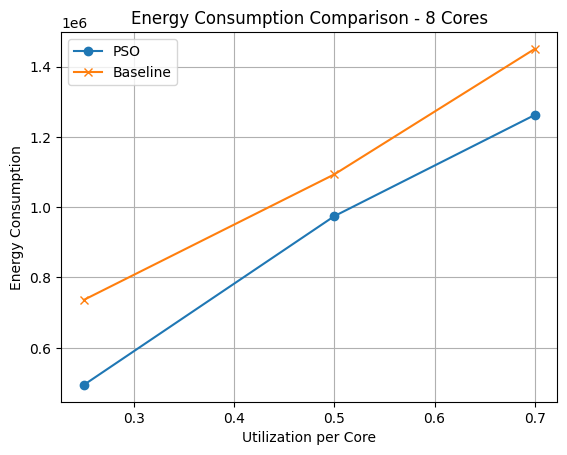


Energy Consumption at 0.25 Utilization (System: 8 Cores): PSO decreased by 32.84%
Energy Consumption at 0.5 Utilization (System: 8 Cores): PSO decreased by 10.87%
Energy Consumption at 0.7 Utilization (System: 8 Cores): PSO decreased by 12.96%

-------------------------------------------------------------------------------------


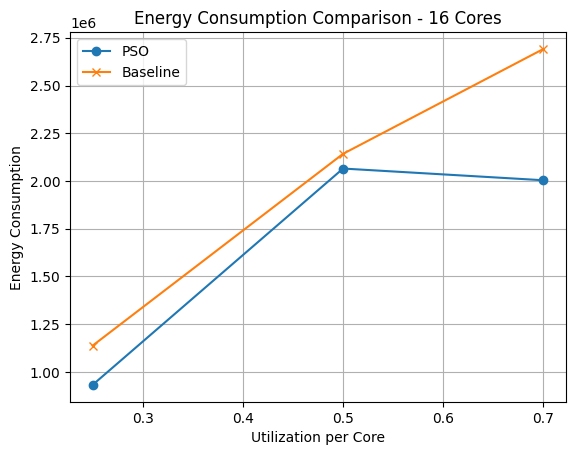


Energy Consumption at 0.25 Utilization (System: 16 Cores): PSO decreased by 18.08%
Energy Consumption at 0.5 Utilization (System: 16 Cores): PSO decreased by 3.60%
Energy Consumption at 0.7 Utilization (System: 16 Cores): PSO decreased by 25.56%

-------------------------------------------------------------------------------------


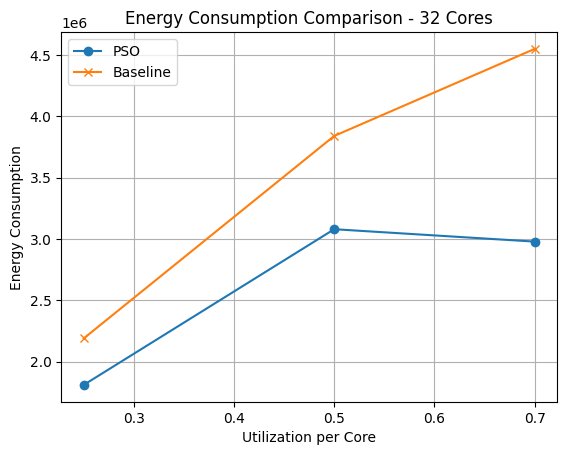


Energy Consumption at 0.25 Utilization (System: 32 Cores): PSO decreased by 17.32%
Energy Consumption at 0.5 Utilization (System: 32 Cores): PSO decreased by 19.80%
Energy Consumption at 0.7 Utilization (System: 32 Cores): PSO decreased by 34.53%

-------------------------------------------------------------------------------------


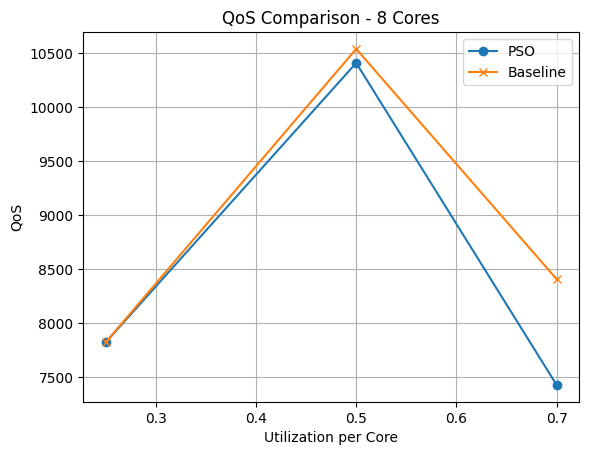


QoS at 0.25 Utilization (System: 8 Cores): PSO decreased by 0.01%
QoS at 0.5 Utilization (System: 8 Cores): PSO decreased by 1.23%
QoS at 0.7 Utilization (System: 8 Cores): PSO decreased by 11.66%

-------------------------------------------------------------------------------------


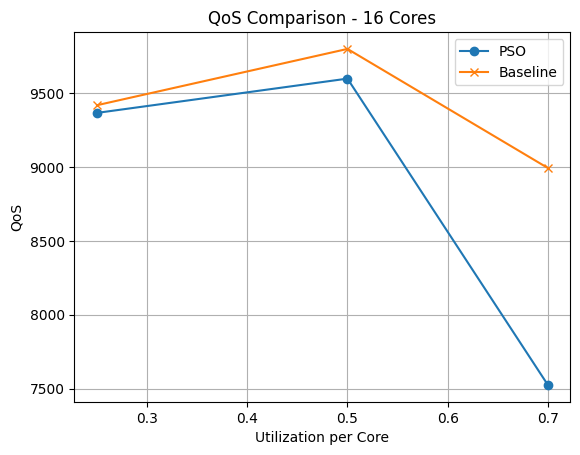


QoS at 0.25 Utilization (System: 16 Cores): PSO decreased by 0.55%
QoS at 0.5 Utilization (System: 16 Cores): PSO decreased by 2.05%
QoS at 0.7 Utilization (System: 16 Cores): PSO decreased by 16.32%

-------------------------------------------------------------------------------------


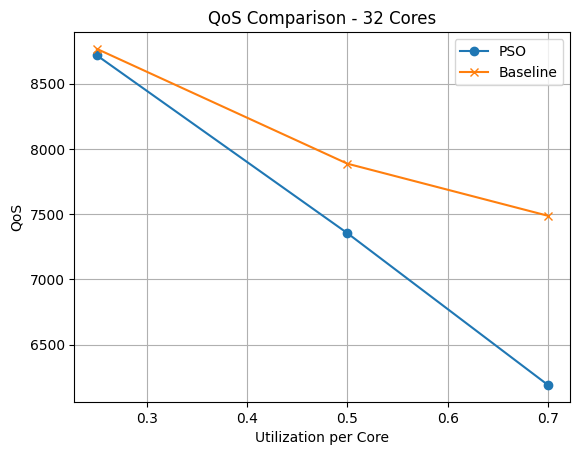


QoS at 0.25 Utilization (System: 32 Cores): PSO decreased by 0.57%
QoS at 0.5 Utilization (System: 32 Cores): PSO decreased by 6.76%
QoS at 0.7 Utilization (System: 32 Cores): PSO decreased by 17.32%

-------------------------------------------------------------------------------------


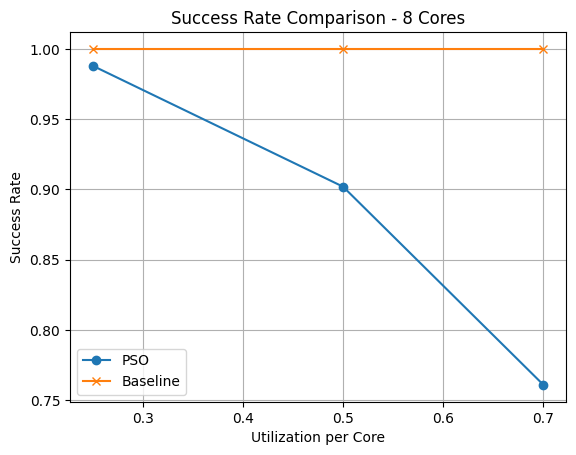


Success Rate at 0.25 Utilization (System: 8 Cores): PSO decreased by 1.19%
Success Rate at 0.5 Utilization (System: 8 Cores): PSO decreased by 9.81%
Success Rate at 0.7 Utilization (System: 8 Cores): PSO decreased by 23.93%

-------------------------------------------------------------------------------------


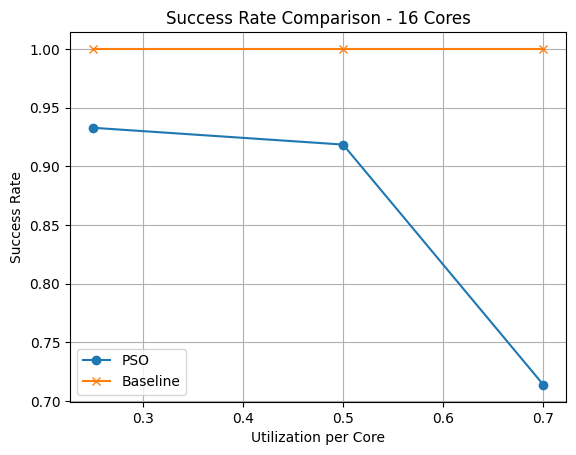


Success Rate at 0.25 Utilization (System: 16 Cores): PSO decreased by 6.71%
Success Rate at 0.5 Utilization (System: 16 Cores): PSO decreased by 8.15%
Success Rate at 0.7 Utilization (System: 16 Cores): PSO decreased by 28.62%

-------------------------------------------------------------------------------------


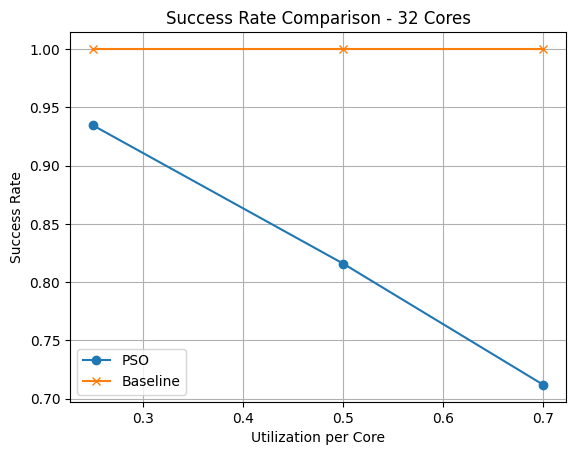


Success Rate at 0.25 Utilization (System: 32 Cores): PSO decreased by 6.54%
Success Rate at 0.5 Utilization (System: 32 Cores): PSO decreased by 18.41%
Success Rate at 0.7 Utilization (System: 32 Cores): PSO decreased by 28.81%



In [ ]:
# Energy Consumption
pso_energy_8_core = [494437, 974455, 1262145]
baseline_energy_8_core = [736250, 1093250, 1450050]

pso_energy_16_core = [931526, 2065022, 2003641]
baseline_energy_16_core = [1137150, 2142150, 2691650]

pso_energy_32_core = [1810374, 3080068, 2979107]
baseline_energy_32_core = [2189550, 3840550, 4550300]

# QoS (Quality of Service)
pso_qos_8_core = [7822, 10410, 7428]
baseline_qos_8_core = [7823, 10540, 8408]

pso_qos_16_core = [9366, 9598, 7525]
baseline_qos_16_core = [9418, 9799, 8993]

pso_qos_32_core = [8717, 7354, 6191]
baseline_qos_32_core = [8767, 7887, 7488]

# Success Rate
pso_success_8_core = [0.9880534082923401, 0.9018906489524783, 0.7607440667094291]
baseline_success_8_core = [1.0, 1.0, 1.0]

pso_success_16_core = [0.9328602620087336, 0.9185232336091661, 0.7138114209827358]
baseline_success_16_core = [1.0, 1.0, 1.0]

pso_success_32_core = [0.9346368715083799, 0.815946348733234, 0.7118881118881119]
baseline_success_32_core = [1.0, 1.0, 1.0]

utilization = [0.25, 0.5, 0.7]

def plot_comparison(pso_data, baseline_data, system_cores, metric_name, utilization):
    print('-------------------------------------------------------------------------------------')
    plt.plot(utilization, pso_data, label="PSO", marker='o')
    plt.plot(utilization, baseline_data, label="Baseline", marker='x')
    plt.xlabel('Utilization per Core')
    plt.ylabel(metric_name)
    plt.title(f'{metric_name} Comparison - {system_cores} Cores')
    plt.legend()
    plt.grid(True)
    plt.show()

    print()
    for i in range(len(utilization)):
        pso_value = pso_data[i]
        baseline_value = baseline_data[i]
        if baseline_value != 0:
            percentage_decrease = ((baseline_value - pso_value) / baseline_value) * 100
        else:
            percentage_decrease = 0
        print(f'{metric_name} at {utilization[i]} Utilization (System: {system_cores} Cores): PSO decreased by {percentage_decrease:.2f}%')
    print()

for system_cores, pso_energy, baseline_energy in zip([8, 16, 32],
                                                     [pso_energy_8_core, pso_energy_16_core, pso_energy_32_core],
                                                     [baseline_energy_8_core, baseline_energy_16_core, baseline_energy_32_core]):
    plot_comparison(pso_energy, baseline_energy, system_cores, 'Energy Consumption', utilization)

for system_cores, pso_qos, baseline_qos in zip([8, 16, 32],
                                               [pso_qos_8_core, pso_qos_16_core, pso_qos_32_core],
                                               [baseline_qos_8_core, baseline_qos_16_core, baseline_qos_32_core]):
    plot_comparison(pso_qos, baseline_qos, system_cores, 'QoS', utilization)

for system_cores, pso_success, baseline_success in zip([8, 16, 32],
                                                       [pso_success_8_core, pso_success_16_core, pso_success_32_core],
                                                       [baseline_success_8_core, baseline_success_16_core, baseline_success_32_core]):
    plot_comparison(pso_success, baseline_success, system_cores, 'Success Rate', utilization)

**Fourth** run:

W = 0.85

C1 = 0.6

C2 = 0.6

In [ ]:
TEST_CASES = [
    (8, 0.25),
    (8, 0.5),
    (8, 0.7),
    (16, 0.25),
    (16, 0.5),
    (16, 0.7),
    (32, 0.25),
    (32, 0.5),
    (32, 0.7),
]

for core_numbers, utilization_per_core in TEST_CASES:
    run_simulation(
        TASK_NUMBERS, core_numbers, utilization_per_core, MAX_HYPER_PERIOD, LAMBDA_PARAM
    )



Core Numbers:  8 , Utilization per Core:  0.25
---------------BaseLine-----------------
Quality of Service: 9223 Energy Consumption:  610300 Success Rate:  1.0


PSO Progress: 100%|██████████| 100/100 [03:58<00:00,  2.38s/it]


---------------PSO Results-----------------
Quality of Service: 9178 Energy Consumption:  422308 Success Rate:  0.9539227895392279


Core Numbers:  8 , Utilization per Core:  0.5
---------------BaseLine-----------------
Quality of Service: 7827 Energy Consumption:  994200 Success Rate:  1.0


PSO Progress: 100%|██████████| 100/100 [03:17<00:00,  1.97s/it]


---------------PSO Results-----------------
Quality of Service: 7508 Energy Consumption:  857179 Success Rate:  0.8739622641509434


Core Numbers:  8 , Utilization per Core:  0.7
---------------BaseLine-----------------
Quality of Service: 8371 Energy Consumption:  1454050 Success Rate:  1.0


PSO Progress: 100%|██████████| 100/100 [04:04<00:00,  2.44s/it]


---------------PSO Results-----------------
Quality of Service: 7540 Energy Consumption:  1376299 Success Rate:  0.74726609963548


Core Numbers:  16 , Utilization per Core:  0.25
---------------BaseLine-----------------
Quality of Service: 8632 Energy Consumption:  1166650 Success Rate:  1.0


PSO Progress: 100%|██████████| 100/100 [04:00<00:00,  2.41s/it]


---------------PSO Results-----------------
Quality of Service: 8567 Energy Consumption:  915548 Success Rate:  0.9428926132836747


Core Numbers:  16 , Utilization per Core:  0.5
---------------BaseLine-----------------
Quality of Service: 9010 Energy Consumption:  2010500 Success Rate:  1.0


PSO Progress: 100%|██████████| 100/100 [03:45<00:00,  2.26s/it]


---------------PSO Results-----------------
Quality of Service: 8466 Energy Consumption:  1876154 Success Rate:  0.7920592193808883


Core Numbers:  16 , Utilization per Core:  0.7
---------------BaseLine-----------------
Quality of Service: 8495 Energy Consumption:  2601800 Success Rate:  1.0


PSO Progress: 100%|██████████| 100/100 [04:08<00:00,  2.49s/it]


---------------PSO Results-----------------
Quality of Service: 6996 Energy Consumption:  2088208 Success Rate:  0.6930203829524397


Core Numbers:  32 , Utilization per Core:  0.25
---------------BaseLine-----------------
Quality of Service: 8797 Energy Consumption:  2198050 Success Rate:  1.0


PSO Progress: 100%|██████████| 100/100 [04:03<00:00,  2.44s/it]


---------------PSO Results-----------------
Quality of Service: 8572 Energy Consumption:  1684737 Success Rate:  0.8755527479469362


Core Numbers:  32 , Utilization per Core:  0.5
---------------BaseLine-----------------
Quality of Service: 10527 Energy Consumption:  4067750 Success Rate:  1.0


PSO Progress: 100%|██████████| 100/100 [04:35<00:00,  2.76s/it]


---------------PSO Results-----------------
Quality of Service: 9133 Energy Consumption:  3277716 Success Rate:  0.7444812362030905


Core Numbers:  32 , Utilization per Core:  0.7
---------------BaseLine-----------------
Quality of Service: 7121 Energy Consumption:  5657700 Success Rate:  1.0


PSO Progress: 100%|██████████| 100/100 [03:50<00:00,  2.31s/it]

---------------PSO Results-----------------
Quality of Service: 5697 Energy Consumption:  4463136 Success Rate:  0.6205298013245033


-------------------------------------------------------------------------------------


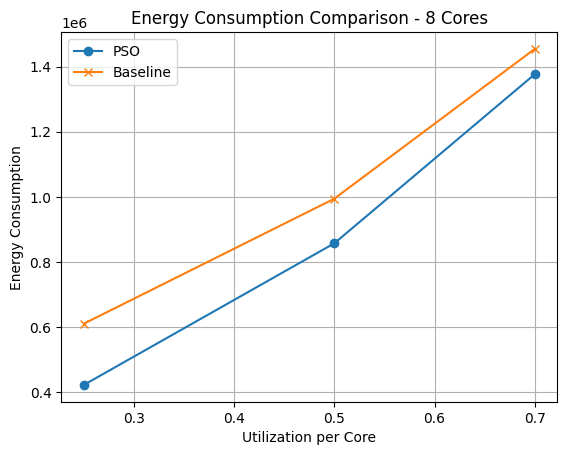


Energy Consumption at 0.25 Utilization (System: 8 Cores): PSO decreased by 30.80%
Energy Consumption at 0.5 Utilization (System: 8 Cores): PSO decreased by 13.78%
Energy Consumption at 0.7 Utilization (System: 8 Cores): PSO decreased by 5.35%

-------------------------------------------------------------------------------------


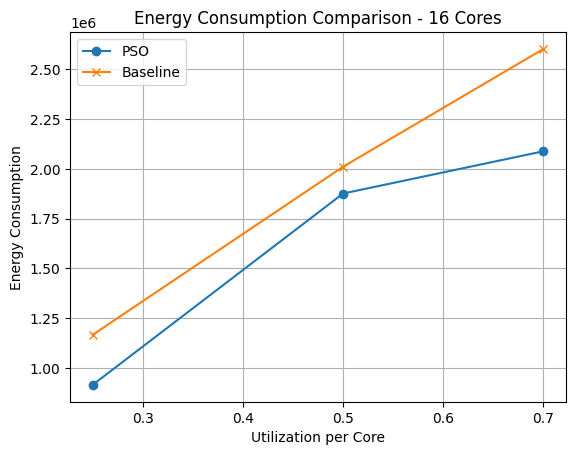


Energy Consumption at 0.25 Utilization (System: 16 Cores): PSO decreased by 21.52%
Energy Consumption at 0.5 Utilization (System: 16 Cores): PSO decreased by 6.68%
Energy Consumption at 0.7 Utilization (System: 16 Cores): PSO decreased by 19.74%

-------------------------------------------------------------------------------------


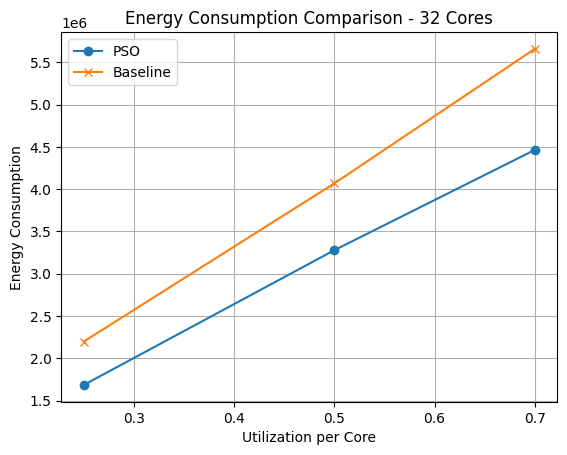


Energy Consumption at 0.25 Utilization (System: 32 Cores): PSO decreased by 23.35%
Energy Consumption at 0.5 Utilization (System: 32 Cores): PSO decreased by 19.42%
Energy Consumption at 0.7 Utilization (System: 32 Cores): PSO decreased by 21.11%

-------------------------------------------------------------------------------------


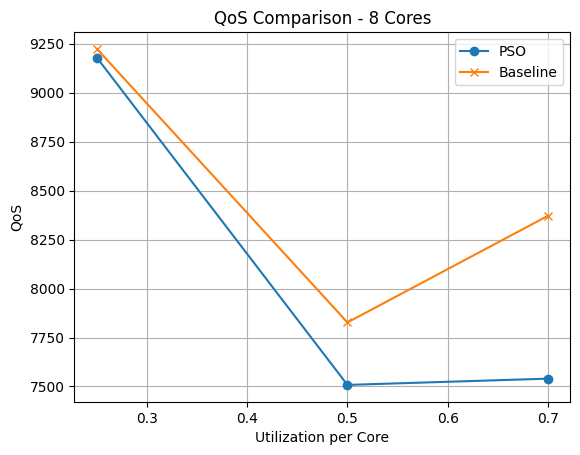


QoS at 0.25 Utilization (System: 8 Cores): PSO decreased by 0.49%
QoS at 0.5 Utilization (System: 8 Cores): PSO decreased by 4.08%
QoS at 0.7 Utilization (System: 8 Cores): PSO decreased by 9.93%

-------------------------------------------------------------------------------------


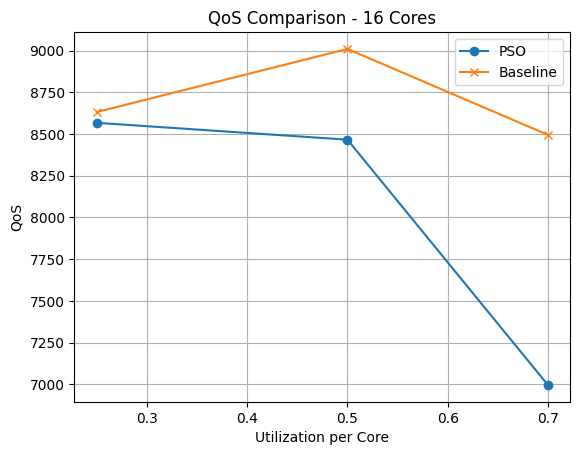


QoS at 0.25 Utilization (System: 16 Cores): PSO decreased by 0.75%
QoS at 0.5 Utilization (System: 16 Cores): PSO decreased by 6.04%
QoS at 0.7 Utilization (System: 16 Cores): PSO decreased by 17.65%

-------------------------------------------------------------------------------------


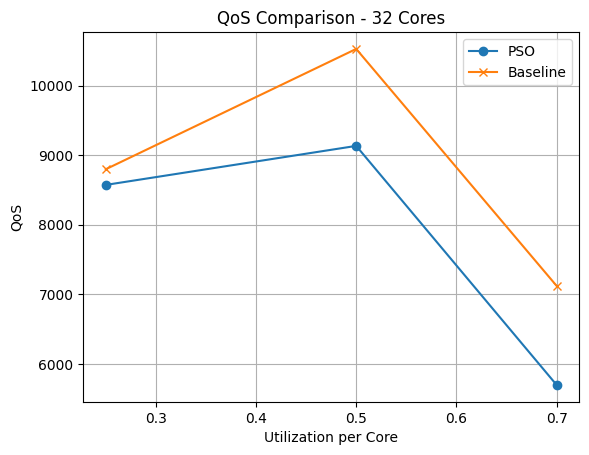


QoS at 0.25 Utilization (System: 32 Cores): PSO decreased by 2.56%
QoS at 0.5 Utilization (System: 32 Cores): PSO decreased by 13.24%
QoS at 0.7 Utilization (System: 32 Cores): PSO decreased by 20.00%

-------------------------------------------------------------------------------------


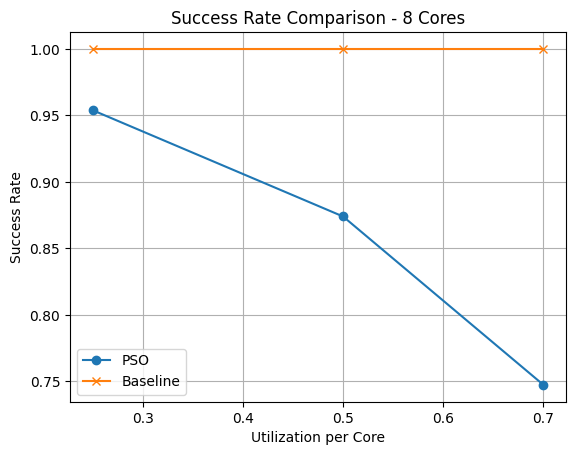


Success Rate at 0.25 Utilization (System: 8 Cores): PSO decreased by 4.61%
Success Rate at 0.5 Utilization (System: 8 Cores): PSO decreased by 12.60%
Success Rate at 0.7 Utilization (System: 8 Cores): PSO decreased by 25.27%

-------------------------------------------------------------------------------------


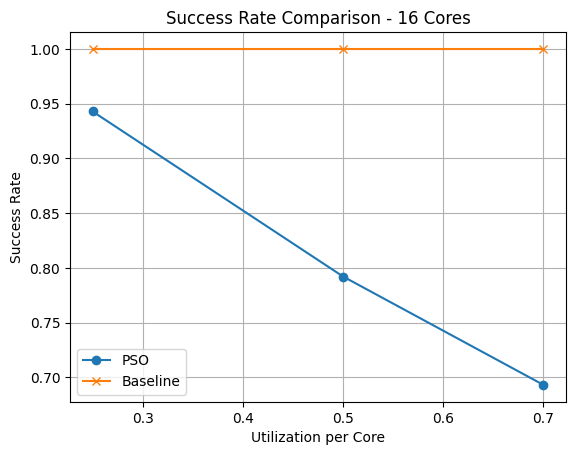


Success Rate at 0.25 Utilization (System: 16 Cores): PSO decreased by 5.71%
Success Rate at 0.5 Utilization (System: 16 Cores): PSO decreased by 20.79%
Success Rate at 0.7 Utilization (System: 16 Cores): PSO decreased by 30.70%

-------------------------------------------------------------------------------------


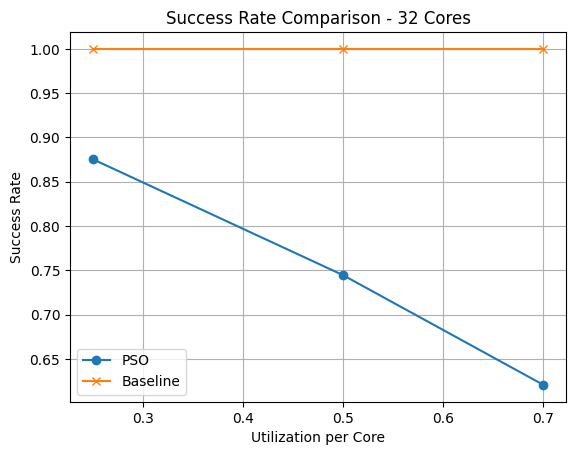


Success Rate at 0.25 Utilization (System: 32 Cores): PSO decreased by 12.44%
Success Rate at 0.5 Utilization (System: 32 Cores): PSO decreased by 25.55%
Success Rate at 0.7 Utilization (System: 32 Cores): PSO decreased by 37.95%



In [ ]:
# Energy Consumption
pso_energy_8_core = [422308, 857179, 1376299]
baseline_energy_8_core = [610300, 994200, 1454050]

pso_energy_16_core = [915548, 1876154, 2088208]
baseline_energy_16_core = [1166650, 2010500, 2601800]

pso_energy_32_core = [1684737, 3277716, 4463136]
baseline_energy_32_core = [2198050, 4067750, 5657700]

# QoS (Quality of Service)
pso_qos_8_core = [9178, 7508, 7540]
baseline_qos_8_core = [9223, 7827, 8371]

pso_qos_16_core = [8567, 8466, 6996]
baseline_qos_16_core = [8632, 9010, 8495]

pso_qos_32_core = [8572, 9133, 5697]
baseline_qos_32_core = [8797, 10527, 7121]

# Success Rate
pso_success_8_core = [0.9539227895392279, 0.8739622641509434, 0.74726609963548]
baseline_success_8_core = [1.0, 1.0, 1.0]

pso_success_16_core = [0.9428926132836747, 0.7920592193808883, 0.6930203829524397]
baseline_success_16_core = [1.0, 1.0, 1.0]

pso_success_32_core = [0.8755527479469362, 0.7444812362030905, 0.6205298013245033]
baseline_success_32_core = [1.0, 1.0, 1.0]

utilization = [0.25, 0.5, 0.7]

def plot_comparison(pso_data, baseline_data, system_cores, metric_name, utilization):
    print('-------------------------------------------------------------------------------------')
    plt.plot(utilization, pso_data, label="PSO", marker='o')
    plt.plot(utilization, baseline_data, label="Baseline", marker='x')
    plt.xlabel('Utilization per Core')
    plt.ylabel(metric_name)
    plt.title(f'{metric_name} Comparison - {system_cores} Cores')
    plt.legend()
    plt.grid(True)
    plt.show()

    print()
    for i in range(len(utilization)):
        pso_value = pso_data[i]
        baseline_value = baseline_data[i]
        if baseline_value != 0:
            percentage_decrease = ((baseline_value - pso_value) / baseline_value) * 100
        else:
            percentage_decrease = 0
        print(f'{metric_name} at {utilization[i]} Utilization (System: {system_cores} Cores): PSO decreased by {percentage_decrease:.2f}%')
    print()

for system_cores, pso_energy, baseline_energy in zip([8, 16, 32],
                                                     [pso_energy_8_core, pso_energy_16_core, pso_energy_32_core],
                                                     [baseline_energy_8_core, baseline_energy_16_core, baseline_energy_32_core]):
    plot_comparison(pso_energy, baseline_energy, system_cores, 'Energy Consumption', utilization)

for system_cores, pso_qos, baseline_qos in zip([8, 16, 32],
                                               [pso_qos_8_core, pso_qos_16_core, pso_qos_32_core],
                                               [baseline_qos_8_core, baseline_qos_16_core, baseline_qos_32_core]):
    plot_comparison(pso_qos, baseline_qos, system_cores, 'QoS', utilization)

for system_cores, pso_success, baseline_success in zip([8, 16, 32],
                                                       [pso_success_8_core, pso_success_16_core, pso_success_32_core],
                                                       [baseline_success_8_core, baseline_success_16_core, baseline_success_32_core]):
    plot_comparison(pso_success, baseline_success, system_cores, 'Success Rate', utilization)

**Third** run:

W = 0.75

C1 = 0.9

C2 = 0.8

In [ ]:
TEST_CASES = [
    (8, 0.25),
    (8, 0.5),
    (8, 0.7),
    (16, 0.25),
    (16, 0.5),
    (16, 0.7),
    (32, 0.25),
    (32, 0.5),
    (32, 0.7),
]

for core_numbers, utilization_per_core in TEST_CASES:
    run_simulation(
        TASK_NUMBERS, core_numbers, utilization_per_core, MAX_HYPER_PERIOD, LAMBDA_PARAM
    )



Core Numbers:  8 , Utilization per Core:  0.25
---------------BaseLine-----------------
Quality of Service: 7424 Energy Consumption:  619750 Success Rate:  1.0


PSO Progress: 100%|██████████| 100/100 [03:30<00:00,  2.11s/it]


---------------PSO Results-----------------
Quality of Service: 7421 Energy Consumption:  471557 Success Rate:  0.985032074126871


Core Numbers:  8 , Utilization per Core:  0.5
---------------BaseLine-----------------
Quality of Service: 8535 Energy Consumption:  1031050 Success Rate:  1.0


PSO Progress: 100%|██████████| 100/100 [04:00<00:00,  2.40s/it]


---------------PSO Results-----------------
Quality of Service: 8337 Energy Consumption:  936282 Success Rate:  0.905123339658444


Core Numbers:  8 , Utilization per Core:  0.7
---------------BaseLine-----------------
Quality of Service: 8137 Energy Consumption:  1467250 Success Rate:  1.0


PSO Progress: 100%|██████████| 100/100 [03:52<00:00,  2.33s/it]


---------------PSO Results-----------------
Quality of Service: 7347 Energy Consumption:  1282909 Success Rate:  0.7751441383728379


Core Numbers:  16 , Utilization per Core:  0.25
---------------BaseLine-----------------
Quality of Service: 7482 Energy Consumption:  1132950 Success Rate:  1.0


PSO Progress: 100%|██████████| 100/100 [03:18<00:00,  1.99s/it]


---------------PSO Results-----------------
Quality of Service: 7358 Energy Consumption:  851551 Success Rate:  0.9200913242009132


Core Numbers:  16 , Utilization per Core:  0.5
---------------BaseLine-----------------
Quality of Service: 9056 Energy Consumption:  2048550 Success Rate:  1.0


PSO Progress: 100%|██████████| 100/100 [04:19<00:00,  2.59s/it]


---------------PSO Results-----------------
Quality of Service: 8405 Energy Consumption:  1690521 Success Rate:  0.8317865429234339


Core Numbers:  16 , Utilization per Core:  0.7
---------------BaseLine-----------------
Quality of Service: 10023 Energy Consumption:  2806050 Success Rate:  1.0


PSO Progress: 100%|██████████| 100/100 [04:02<00:00,  2.43s/it]


---------------PSO Results-----------------
Quality of Service: 9158 Energy Consumption:  2068690 Success Rate:  0.7963997517070143


Core Numbers:  32 , Utilization per Core:  0.25
---------------BaseLine-----------------
Quality of Service: 8945 Energy Consumption:  2064250 Success Rate:  1.0


PSO Progress: 100%|██████████| 100/100 [04:41<00:00,  2.81s/it]


---------------PSO Results-----------------
Quality of Service: 8795 Energy Consumption:  1592877 Success Rate:  0.9440596696856686


Core Numbers:  32 , Utilization per Core:  0.5
---------------BaseLine-----------------
Quality of Service: 7165 Energy Consumption:  4297550 Success Rate:  1.0


PSO Progress: 100%|██████████| 100/100 [03:17<00:00,  1.98s/it]


---------------PSO Results-----------------
Quality of Service: 6367 Energy Consumption:  3507299 Success Rate:  0.8045801526717558


Core Numbers:  32 , Utilization per Core:  0.7
---------------BaseLine-----------------
Quality of Service: 8740 Energy Consumption:  5943700 Success Rate:  1.0


PSO Progress: 100%|██████████| 100/100 [04:03<00:00,  2.43s/it]

---------------PSO Results-----------------
Quality of Service: 7054 Energy Consumption:  4480449 Success Rate:  0.689375


-------------------------------------------------------------------------------------


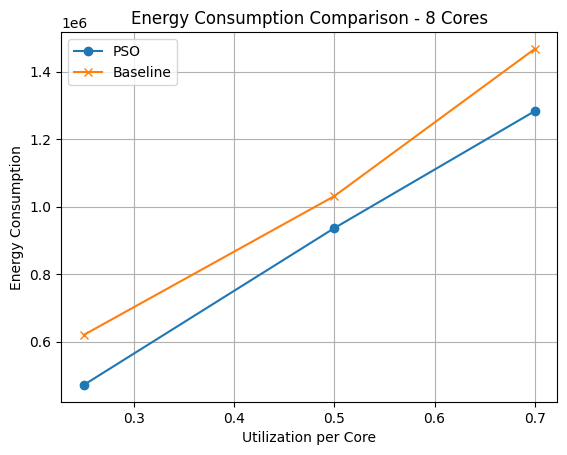


Energy Consumption at 0.25 Utilization (System: 8 Cores): PSO decreased by 23.91%
Energy Consumption at 0.5 Utilization (System: 8 Cores): PSO decreased by 9.19%
Energy Consumption at 0.7 Utilization (System: 8 Cores): PSO decreased by 12.56%

-------------------------------------------------------------------------------------


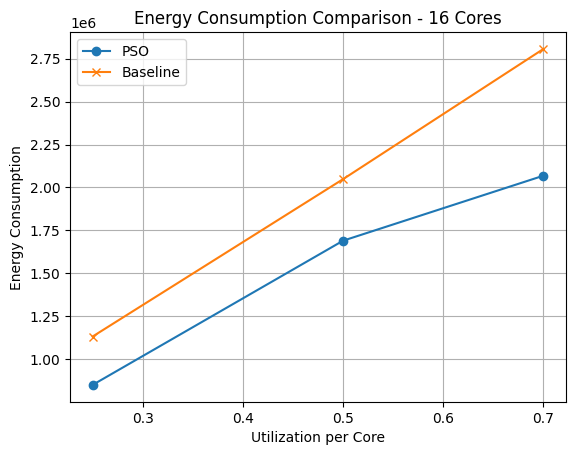


Energy Consumption at 0.25 Utilization (System: 16 Cores): PSO decreased by 24.84%
Energy Consumption at 0.5 Utilization (System: 16 Cores): PSO decreased by 17.48%
Energy Consumption at 0.7 Utilization (System: 16 Cores): PSO decreased by 26.28%

-------------------------------------------------------------------------------------


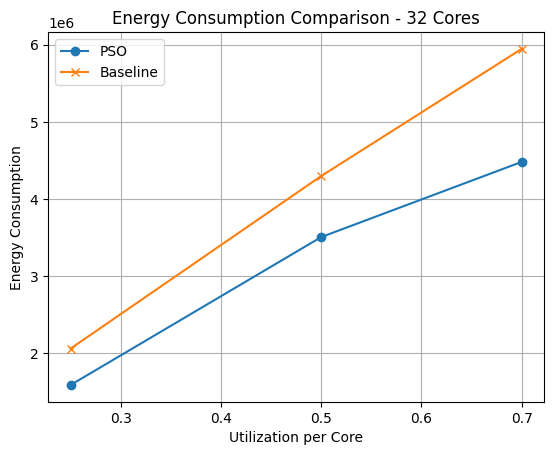


Energy Consumption at 0.25 Utilization (System: 32 Cores): PSO decreased by 22.84%
Energy Consumption at 0.5 Utilization (System: 32 Cores): PSO decreased by 18.39%
Energy Consumption at 0.7 Utilization (System: 32 Cores): PSO decreased by 24.62%

-------------------------------------------------------------------------------------


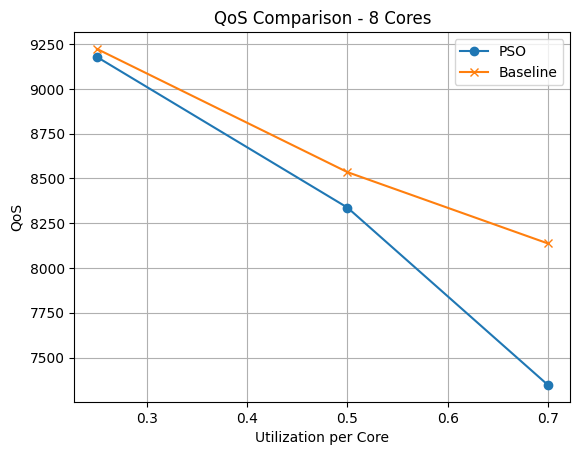


QoS at 0.25 Utilization (System: 8 Cores): PSO decreased by 0.49%
QoS at 0.5 Utilization (System: 8 Cores): PSO decreased by 2.32%
QoS at 0.7 Utilization (System: 8 Cores): PSO decreased by 9.71%

-------------------------------------------------------------------------------------


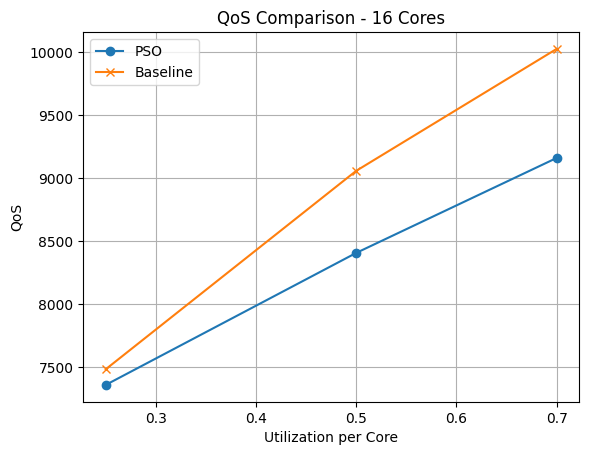


QoS at 0.25 Utilization (System: 16 Cores): PSO decreased by 1.66%
QoS at 0.5 Utilization (System: 16 Cores): PSO decreased by 7.19%
QoS at 0.7 Utilization (System: 16 Cores): PSO decreased by 8.63%

-------------------------------------------------------------------------------------


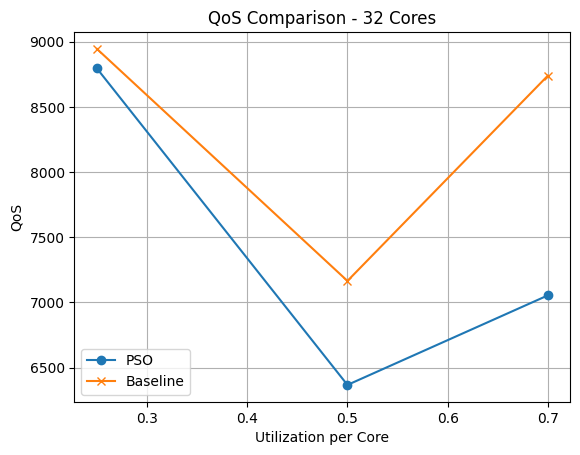


QoS at 0.25 Utilization (System: 32 Cores): PSO decreased by 1.68%
QoS at 0.5 Utilization (System: 32 Cores): PSO decreased by 11.14%
QoS at 0.7 Utilization (System: 32 Cores): PSO decreased by 19.29%

-------------------------------------------------------------------------------------


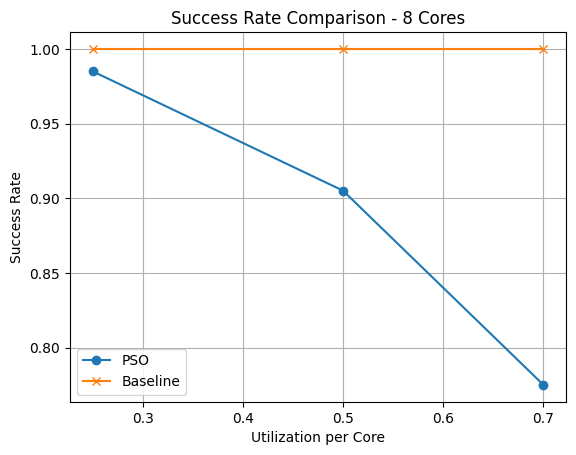


Success Rate at 0.25 Utilization (System: 8 Cores): PSO decreased by 1.50%
Success Rate at 0.5 Utilization (System: 8 Cores): PSO decreased by 9.49%
Success Rate at 0.7 Utilization (System: 8 Cores): PSO decreased by 22.49%

-------------------------------------------------------------------------------------


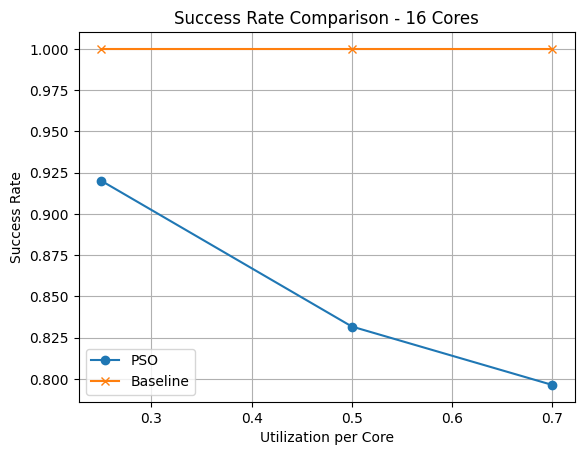


Success Rate at 0.25 Utilization (System: 16 Cores): PSO decreased by 7.99%
Success Rate at 0.5 Utilization (System: 16 Cores): PSO decreased by 16.82%
Success Rate at 0.7 Utilization (System: 16 Cores): PSO decreased by 20.36%

-------------------------------------------------------------------------------------


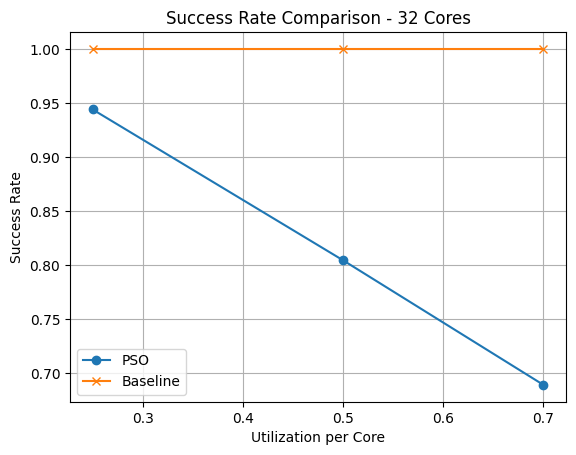


Success Rate at 0.25 Utilization (System: 32 Cores): PSO decreased by 5.59%
Success Rate at 0.5 Utilization (System: 32 Cores): PSO decreased by 19.54%
Success Rate at 0.7 Utilization (System: 32 Cores): PSO decreased by 31.06%



In [ ]:
# Energy Consumption
pso_energy_8_core = [471557, 936282, 1282909]
baseline_energy_8_core = [619750, 1031050, 1467250]

pso_energy_16_core = [851551, 1690521, 2068690]
baseline_energy_16_core = [1132950, 2048550, 2806050]

pso_energy_32_core = [1592877, 3507299, 4480449]
baseline_energy_32_core = [2064250, 4297550, 5943700]

# QoS (Quality of Service)
pso_qos_8_core = [9178, 8337, 7347]
baseline_qos_8_core = [9223, 8535, 8137]

pso_qos_16_core = [7358, 8405, 9158]
baseline_qos_16_core = [7482, 9056, 10023]

pso_qos_32_core = [8795, 6367, 7054]
baseline_qos_32_core = [8945, 7165, 8740]

# Success Rate
pso_success_8_core = [0.985032074126871, 0.905123339658444, 0.7751441383728379]
baseline_success_8_core = [1.0, 1.0, 1.0]

pso_success_16_core = [0.9200913242009132, 0.8317865429234339, 0.7963997517070143]
baseline_success_16_core = [1.0, 1.0, 1.0]

pso_success_32_core = [0.9440596696856686, 0.8045801526717558, 0.689375]
baseline_success_32_core = [1.0, 1.0, 1.0]

utilization = [0.25, 0.5, 0.7]

def plot_comparison(pso_data, baseline_data, system_cores, metric_name, utilization):
    print('-------------------------------------------------------------------------------------')
    plt.plot(utilization, pso_data, label="PSO", marker='o')
    plt.plot(utilization, baseline_data, label="Baseline", marker='x')
    plt.xlabel('Utilization per Core')
    plt.ylabel(metric_name)
    plt.title(f'{metric_name} Comparison - {system_cores} Cores')
    plt.legend()
    plt.grid(True)
    plt.show()

    print()
    for i in range(len(utilization)):
        pso_value = pso_data[i]
        baseline_value = baseline_data[i]
        if baseline_value != 0:
            percentage_decrease = ((baseline_value - pso_value) / baseline_value) * 100
        else:
            percentage_decrease = 0
        print(f'{metric_name} at {utilization[i]} Utilization (System: {system_cores} Cores): PSO decreased by {percentage_decrease:.2f}%')
    print()

for system_cores, pso_energy, baseline_energy in zip([8, 16, 32],
                                                     [pso_energy_8_core, pso_energy_16_core, pso_energy_32_core],
                                                     [baseline_energy_8_core, baseline_energy_16_core, baseline_energy_32_core]):
    plot_comparison(pso_energy, baseline_energy, system_cores, 'Energy Consumption', utilization)

for system_cores, pso_qos, baseline_qos in zip([8, 16, 32],
                                               [pso_qos_8_core, pso_qos_16_core, pso_qos_32_core],
                                               [baseline_qos_8_core, baseline_qos_16_core, baseline_qos_32_core]):
    plot_comparison(pso_qos, baseline_qos, system_cores, 'QoS', utilization)

for system_cores, pso_success, baseline_success in zip([8, 16, 32],
                                                       [pso_success_8_core, pso_success_16_core, pso_success_32_core],
                                                       [baseline_success_8_core, baseline_success_16_core, baseline_success_32_core]):
    plot_comparison(pso_success, baseline_success, system_cores, 'Success Rate', utilization)

**Second** run:

W = 0.5

C1 = 0.8

C2 = 0.7

In [ ]:
TEST_CASES = [
    (8, 0.25),
    (8, 0.5),
    (8, 0.7),
    (16, 0.25),
    (16, 0.5),
    (16, 0.7),
    (32, 0.25),
    (32, 0.5),
    (32, 0.7),
]

for core_numbers, utilization_per_core in TEST_CASES:
    run_simulation(
        TASK_NUMBERS, core_numbers, utilization_per_core, MAX_HYPER_PERIOD, LAMBDA_PARAM
    )



Core Numbers:  8 , Utilization per Core:  0.25
---------------BaseLine-----------------
Quality of Service: 8236 Energy Consumption:  719550 Success Rate:  1.0


PSO Progress: 100%|██████████| 100/100 [03:54<00:00,  2.34s/it]


---------------PSO Results-----------------
Quality of Service: 8173 Energy Consumption:  400663 Success Rate:  0.9679446888749215


Core Numbers:  8 , Utilization per Core:  0.5
---------------BaseLine-----------------
Quality of Service: 9198 Energy Consumption:  1057200 Success Rate:  1.0


PSO Progress: 100%|██████████| 100/100 [04:14<00:00,  2.55s/it]


---------------PSO Results-----------------
Quality of Service: 8874 Energy Consumption:  909540 Success Rate:  0.8865083960625362


Core Numbers:  8 , Utilization per Core:  0.7
---------------BaseLine-----------------
Quality of Service: 8819 Energy Consumption:  1445000 Success Rate:  1.0


PSO Progress: 100%|██████████| 100/100 [04:30<00:00,  2.70s/it]


---------------PSO Results-----------------
Quality of Service: 7139 Energy Consumption:  1009617 Success Rate:  0.7317339149400218


Core Numbers:  16 , Utilization per Core:  0.25
---------------BaseLine-----------------
Quality of Service: 8347 Energy Consumption:  1109250 Success Rate:  1.0


PSO Progress: 100%|██████████| 100/100 [03:30<00:00,  2.11s/it]


---------------PSO Results-----------------
Quality of Service: 8304 Energy Consumption:  862781 Success Rate:  0.9653954802259888


Core Numbers:  16 , Utilization per Core:  0.5
---------------BaseLine-----------------
Quality of Service: 8727 Energy Consumption:  1890500 Success Rate:  1.0


PSO Progress: 100%|██████████| 100/100 [04:04<00:00,  2.45s/it]


---------------PSO Results-----------------
Quality of Service: 7811 Energy Consumption:  1545740 Success Rate:  0.7863247863247863


Core Numbers:  16 , Utilization per Core:  0.7
---------------BaseLine-----------------
Quality of Service: 8552 Energy Consumption:  2818650 Success Rate:  1.0


PSO Progress: 100%|██████████| 100/100 [03:59<00:00,  2.40s/it]


---------------PSO Results-----------------
Quality of Service: 6749 Energy Consumption:  2266878 Success Rate:  0.6414267834793492


Core Numbers:  32 , Utilization per Core:  0.25
---------------BaseLine-----------------
Quality of Service: 9797 Energy Consumption:  1929350 Success Rate:  1.0


PSO Progress: 100%|██████████| 100/100 [04:34<00:00,  2.74s/it]


---------------PSO Results-----------------
Quality of Service: 9486 Energy Consumption:  1540274 Success Rate:  0.8852013057671382


Core Numbers:  32 , Utilization per Core:  0.5
---------------BaseLine-----------------
Quality of Service: 9887 Energy Consumption:  3469600 Success Rate:  1.0


PSO Progress: 100%|██████████| 100/100 [04:12<00:00,  2.52s/it]


---------------PSO Results-----------------
Quality of Service: 8351 Energy Consumption:  2643567 Success Rate:  0.7307012374779022


Core Numbers:  32 , Utilization per Core:  0.7
---------------BaseLine-----------------
Quality of Service: 8519 Energy Consumption:  5631950 Success Rate:  1.0


PSO Progress: 100%|██████████| 100/100 [04:03<00:00,  2.44s/it]

---------------PSO Results-----------------
Quality of Service: 5954 Energy Consumption:  4269613 Success Rate:  0.5727496917385944


-------------------------------------------------------------------------------------


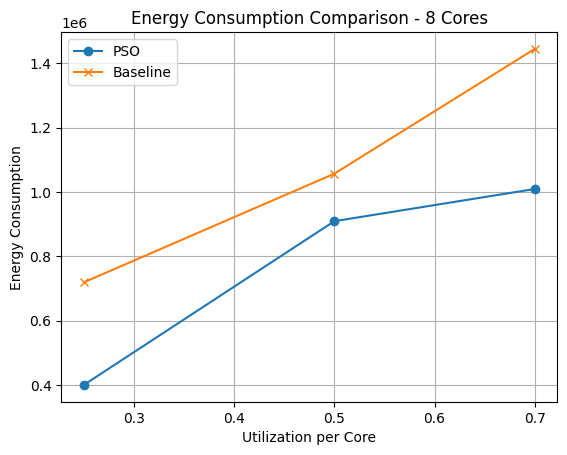


Energy Consumption at 0.25 Utilization (System: 8 Cores): PSO decreased by 44.32%
Energy Consumption at 0.5 Utilization (System: 8 Cores): PSO decreased by 13.97%
Energy Consumption at 0.7 Utilization (System: 8 Cores): PSO decreased by 30.13%

-------------------------------------------------------------------------------------


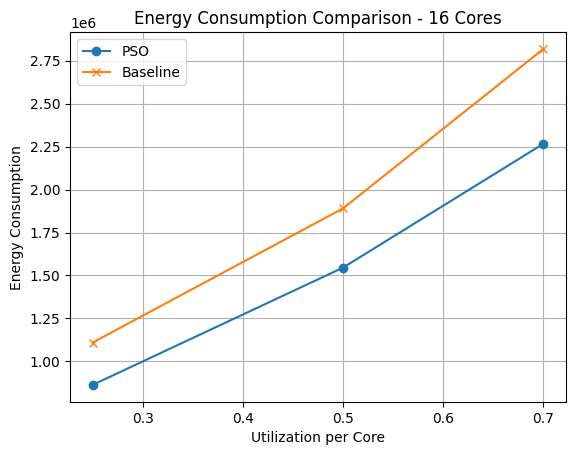


Energy Consumption at 0.25 Utilization (System: 16 Cores): PSO decreased by 22.22%
Energy Consumption at 0.5 Utilization (System: 16 Cores): PSO decreased by 18.24%
Energy Consumption at 0.7 Utilization (System: 16 Cores): PSO decreased by 19.58%

-------------------------------------------------------------------------------------


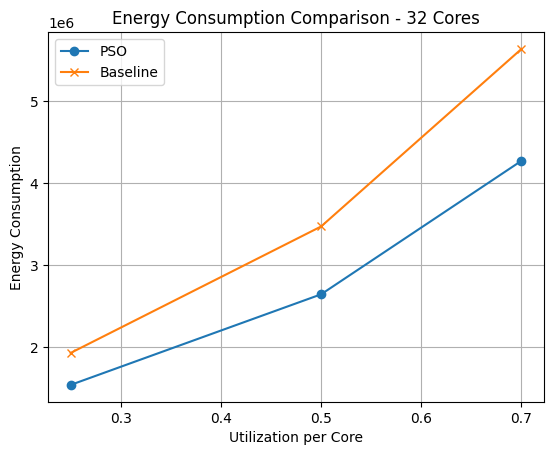


Energy Consumption at 0.25 Utilization (System: 32 Cores): PSO decreased by 20.17%
Energy Consumption at 0.5 Utilization (System: 32 Cores): PSO decreased by 23.81%
Energy Consumption at 0.7 Utilization (System: 32 Cores): PSO decreased by 24.19%

-------------------------------------------------------------------------------------


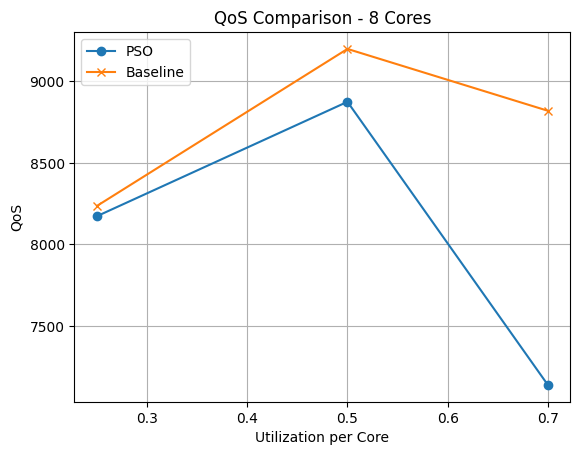


QoS at 0.25 Utilization (System: 8 Cores): PSO decreased by 0.76%
QoS at 0.5 Utilization (System: 8 Cores): PSO decreased by 3.52%
QoS at 0.7 Utilization (System: 8 Cores): PSO decreased by 19.05%

-------------------------------------------------------------------------------------


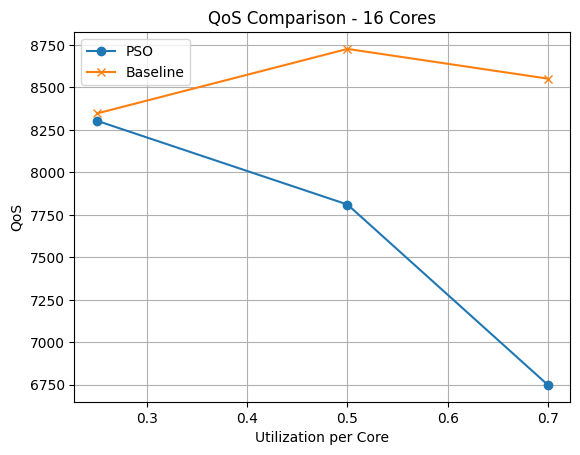


QoS at 0.25 Utilization (System: 16 Cores): PSO decreased by 0.52%
QoS at 0.5 Utilization (System: 16 Cores): PSO decreased by 10.50%
QoS at 0.7 Utilization (System: 16 Cores): PSO decreased by 21.08%

-------------------------------------------------------------------------------------


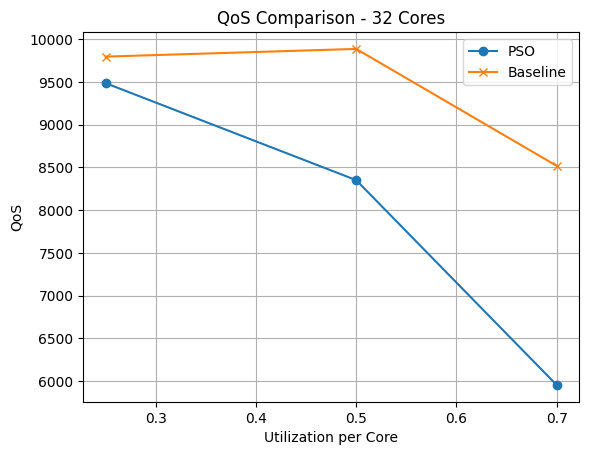


QoS at 0.25 Utilization (System: 32 Cores): PSO decreased by 3.17%
QoS at 0.5 Utilization (System: 32 Cores): PSO decreased by 15.54%
QoS at 0.7 Utilization (System: 32 Cores): PSO decreased by 30.11%

-------------------------------------------------------------------------------------


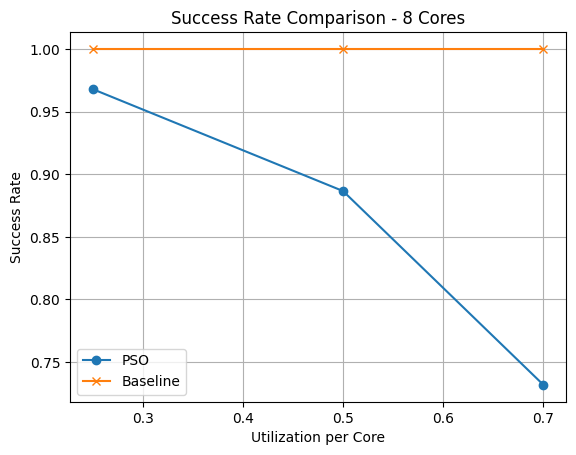


Success Rate at 0.25 Utilization (System: 8 Cores): PSO decreased by 3.21%
Success Rate at 0.5 Utilization (System: 8 Cores): PSO decreased by 11.35%
Success Rate at 0.7 Utilization (System: 8 Cores): PSO decreased by 26.83%

-------------------------------------------------------------------------------------


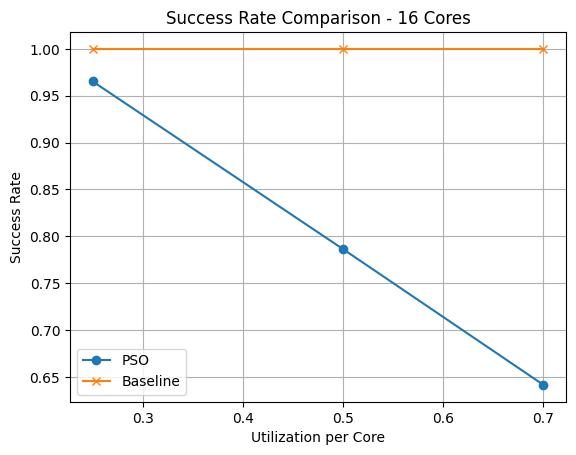


Success Rate at 0.25 Utilization (System: 16 Cores): PSO decreased by 3.46%
Success Rate at 0.5 Utilization (System: 16 Cores): PSO decreased by 21.37%
Success Rate at 0.7 Utilization (System: 16 Cores): PSO decreased by 35.86%

-------------------------------------------------------------------------------------


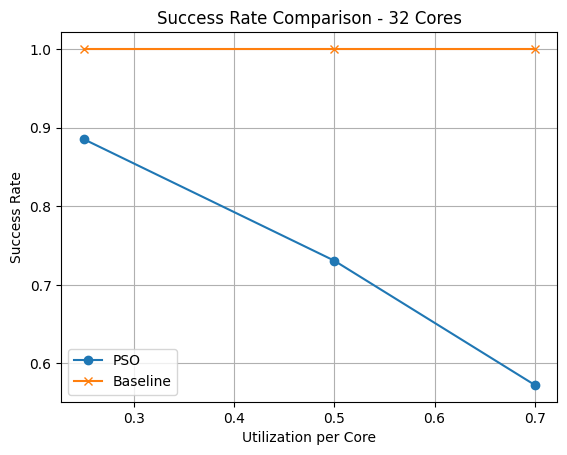


Success Rate at 0.25 Utilization (System: 32 Cores): PSO decreased by 11.48%
Success Rate at 0.5 Utilization (System: 32 Cores): PSO decreased by 26.93%
Success Rate at 0.7 Utilization (System: 32 Cores): PSO decreased by 42.73%



In [ ]:
# Energy Consumption
pso_energy_8_core = [400663, 909540, 1009617]
baseline_energy_8_core = [719550, 1057200, 1445000]

pso_energy_16_core = [862781, 1545740, 2266878]
baseline_energy_16_core = [1109250, 1890500, 2818650]

pso_energy_32_core = [1540274, 2643567, 4269613]
baseline_energy_32_core = [1929350, 3469600, 5631950]

# QoS (Quality of Service)
pso_qos_8_core = [8173, 8874, 7139]
baseline_qos_8_core = [8236, 9198, 8819]

pso_qos_16_core = [8304, 7811, 6749]
baseline_qos_16_core = [8347, 8727, 8552]

pso_qos_32_core = [9486, 8351, 5954]
baseline_qos_32_core = [9797, 9887, 8519]

# Success Rate
pso_success_8_core = [0.9679446888749215, 0.8865083960625362, 0.7317339149400218]
baseline_success_8_core = [1.0, 1.0, 1.0]

pso_success_16_core = [0.9653954802259888, 0.7863247863247863, 0.6414267834793492]
baseline_success_16_core = [1.0, 1.0, 1.0]

pso_success_32_core = [0.8852013057671382, 0.7307012374779022, 0.5727496917385944]
baseline_success_32_core = [1.0, 1.0, 1.0]

utilization = [0.25, 0.5, 0.7]

def plot_comparison(pso_data, baseline_data, system_cores, metric_name, utilization):
    print('-------------------------------------------------------------------------------------')
    plt.plot(utilization, pso_data, label="PSO", marker='o')
    plt.plot(utilization, baseline_data, label="Baseline", marker='x')
    plt.xlabel('Utilization per Core')
    plt.ylabel(metric_name)
    plt.title(f'{metric_name} Comparison - {system_cores} Cores')
    plt.legend()
    plt.grid(True)
    plt.show()

    print()
    for i in range(len(utilization)):
        pso_value = pso_data[i]
        baseline_value = baseline_data[i]
        if baseline_value != 0:
            percentage_decrease = ((baseline_value - pso_value) / baseline_value) * 100
        else:
            percentage_decrease = 0
        print(f'{metric_name} at {utilization[i]} Utilization (System: {system_cores} Cores): PSO decreased by {percentage_decrease:.2f}%')
    print()

for system_cores, pso_energy, baseline_energy in zip([8, 16, 32],
                                                     [pso_energy_8_core, pso_energy_16_core, pso_energy_32_core],
                                                     [baseline_energy_8_core, baseline_energy_16_core, baseline_energy_32_core]):
    plot_comparison(pso_energy, baseline_energy, system_cores, 'Energy Consumption', utilization)

for system_cores, pso_qos, baseline_qos in zip([8, 16, 32],
                                               [pso_qos_8_core, pso_qos_16_core, pso_qos_32_core],
                                               [baseline_qos_8_core, baseline_qos_16_core, baseline_qos_32_core]):
    plot_comparison(pso_qos, baseline_qos, system_cores, 'QoS', utilization)

for system_cores, pso_success, baseline_success in zip([8, 16, 32],
                                                       [pso_success_8_core, pso_success_16_core, pso_success_32_core],
                                                       [baseline_success_8_core, baseline_success_16_core, baseline_success_32_core]):
    plot_comparison(pso_success, baseline_success, system_cores, 'Success Rate', utilization)

**First** run:

W = 0.5

C1 = 1.0

C2 = 1.0

In [ ]:
TEST_CASES = [
    (8, 0.25),
    (8, 0.5),
    (8, 0.7),
    (16, 0.25),
    (16, 0.5),
    (16, 0.7),
    (32, 0.25),
    (32, 0.5),
    (32, 0.7),
]

for core_numbers, utilization_per_core in TEST_CASES:
    run_simulation(
        TASK_NUMBERS, core_numbers, utilization_per_core, MAX_HYPER_PERIOD, LAMBDA_PARAM
    )



Core Numbers:  8 , Utilization per Core:  0.25
---------------BaseLine-----------------
Quality of Service: 10606 Energy Consumption:  740550 Success Rate:  1.0


PSO Progress: 100%|██████████| 50/50 [02:01<00:00,  2.43s/it]


---------------PSO Results-----------------
Quality of Service: 10587 Energy Consumption:  425549 Success Rate:  0.9731266149870801


Core Numbers:  8 , Utilization per Core:  0.5
---------------BaseLine-----------------
Quality of Service: 8068 Energy Consumption:  994900 Success Rate:  1.0


PSO Progress: 100%|██████████| 50/50 [01:37<00:00,  1.95s/it]


---------------PSO Results-----------------
Quality of Service: 7534 Energy Consumption:  815980 Success Rate:  0.8604651162790697


Core Numbers:  8 , Utilization per Core:  0.7
---------------BaseLine-----------------
Quality of Service: 9149 Energy Consumption:  1496950 Success Rate:  1.0


PSO Progress: 100%|██████████| 50/50 [02:00<00:00,  2.41s/it]


---------------PSO Results-----------------
Quality of Service: 8149 Energy Consumption:  1325929 Success Rate:  0.7384535547483134


Core Numbers:  16 , Utilization per Core:  0.25
---------------BaseLine-----------------
Quality of Service: 9773 Energy Consumption:  1106250 Success Rate:  1.0


PSO Progress: 100%|██████████| 50/50 [01:46<00:00,  2.13s/it]


---------------PSO Results-----------------
Quality of Service: 9680 Energy Consumption:  835239 Success Rate:  0.9579268292682926


Core Numbers:  16 , Utilization per Core:  0.5
---------------BaseLine-----------------
Quality of Service: 7040 Energy Consumption:  1926600 Success Rate:  1.0


PSO Progress: 100%|██████████| 50/50 [01:20<00:00,  1.60s/it]


---------------PSO Results-----------------
Quality of Service: 6539 Energy Consumption:  1682445 Success Rate:  0.8399034593724859


Core Numbers:  16 , Utilization per Core:  0.7
---------------BaseLine-----------------
Quality of Service: 7826 Energy Consumption:  2750550 Success Rate:  1.0


PSO Progress: 100%|██████████| 50/50 [01:37<00:00,  1.96s/it]


---------------PSO Results-----------------
Quality of Service: 6799 Energy Consumption:  2299803 Success Rate:  0.7104420243433697


Core Numbers:  32 , Utilization per Core:  0.25
---------------BaseLine-----------------
Quality of Service: 8929 Energy Consumption:  2120500 Success Rate:  1.0


PSO Progress: 100%|██████████| 50/50 [01:43<00:00,  2.06s/it]


---------------PSO Results-----------------
Quality of Service: 8783 Energy Consumption:  1586213 Success Rate:  0.9329774614472124


Core Numbers:  32 , Utilization per Core:  0.5
---------------BaseLine-----------------
Quality of Service: 8674 Energy Consumption:  4629200 Success Rate:  1.0


PSO Progress: 100%|██████████| 50/50 [01:42<00:00,  2.05s/it]


---------------PSO Results-----------------
Quality of Service: 7513 Energy Consumption:  3541284 Success Rate:  0.7627118644067796


Core Numbers:  32 , Utilization per Core:  0.7
---------------BaseLine-----------------
Quality of Service: 8215 Energy Consumption:  5518950 Success Rate:  1.0


PSO Progress: 100%|██████████| 50/50 [01:29<00:00,  1.80s/it]

---------------PSO Results-----------------
Quality of Service: 5927 Energy Consumption:  4114233 Success Rate:  0.6032078103207811


-------------------------------------------------------------------------------------


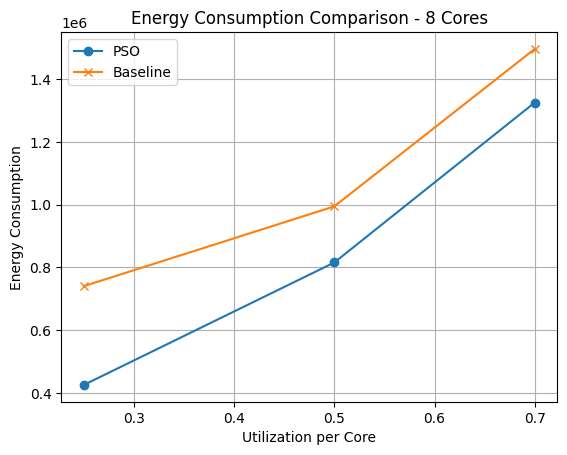


Energy Consumption at 0.25 Utilization (System: 8 Cores): PSO decreased by 42.54%
Energy Consumption at 0.5 Utilization (System: 8 Cores): PSO decreased by 17.98%
Energy Consumption at 0.7 Utilization (System: 8 Cores): PSO decreased by 11.42%

-------------------------------------------------------------------------------------


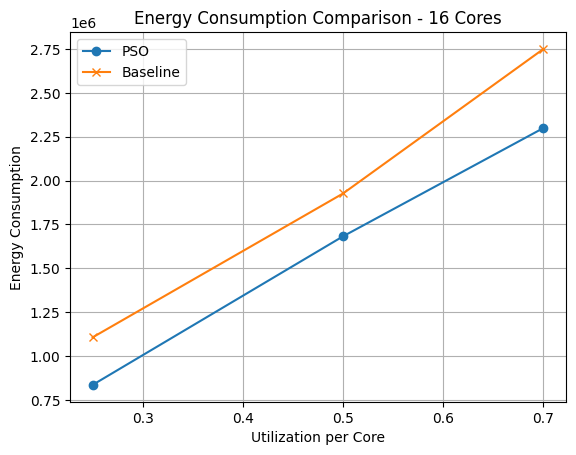


Energy Consumption at 0.25 Utilization (System: 16 Cores): PSO decreased by 24.50%
Energy Consumption at 0.5 Utilization (System: 16 Cores): PSO decreased by 12.67%
Energy Consumption at 0.7 Utilization (System: 16 Cores): PSO decreased by 16.39%

-------------------------------------------------------------------------------------


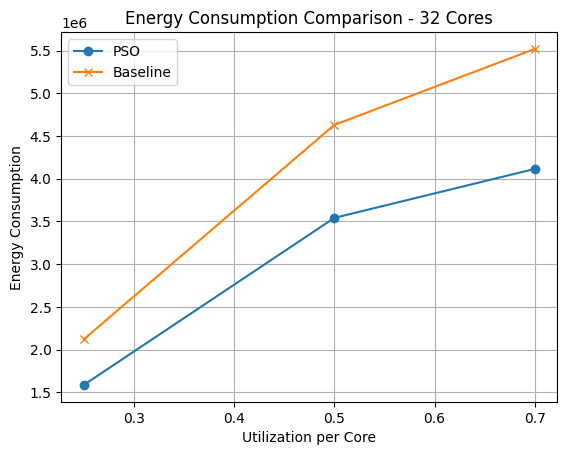


Energy Consumption at 0.25 Utilization (System: 32 Cores): PSO decreased by 25.20%
Energy Consumption at 0.5 Utilization (System: 32 Cores): PSO decreased by 23.50%
Energy Consumption at 0.7 Utilization (System: 32 Cores): PSO decreased by 25.45%

-------------------------------------------------------------------------------------


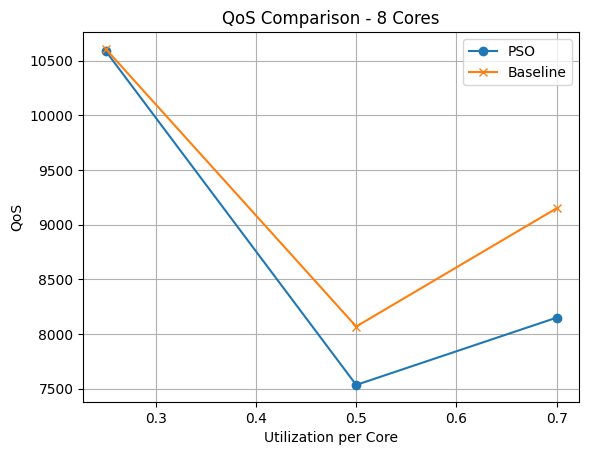


QoS at 0.25 Utilization (System: 8 Cores): PSO decreased by 0.18%
QoS at 0.5 Utilization (System: 8 Cores): PSO decreased by 6.62%
QoS at 0.7 Utilization (System: 8 Cores): PSO decreased by 10.93%

-------------------------------------------------------------------------------------


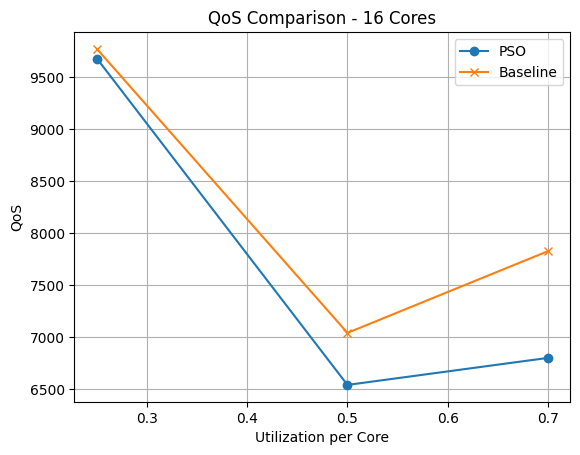


QoS at 0.25 Utilization (System: 16 Cores): PSO decreased by 0.95%
QoS at 0.5 Utilization (System: 16 Cores): PSO decreased by 7.12%
QoS at 0.7 Utilization (System: 16 Cores): PSO decreased by 13.12%

-------------------------------------------------------------------------------------


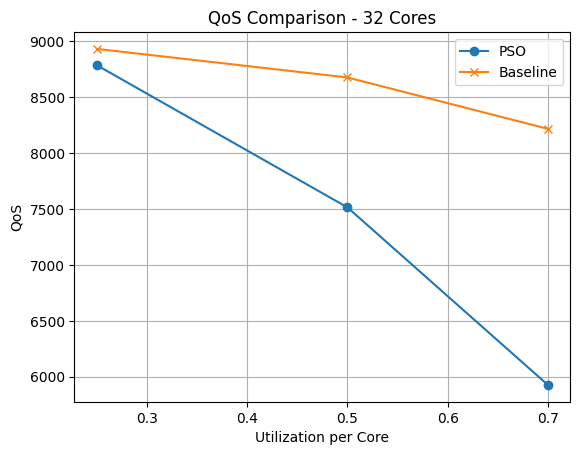


QoS at 0.25 Utilization (System: 32 Cores): PSO decreased by 1.64%
QoS at 0.5 Utilization (System: 32 Cores): PSO decreased by 13.38%
QoS at 0.7 Utilization (System: 32 Cores): PSO decreased by 27.85%

-------------------------------------------------------------------------------------


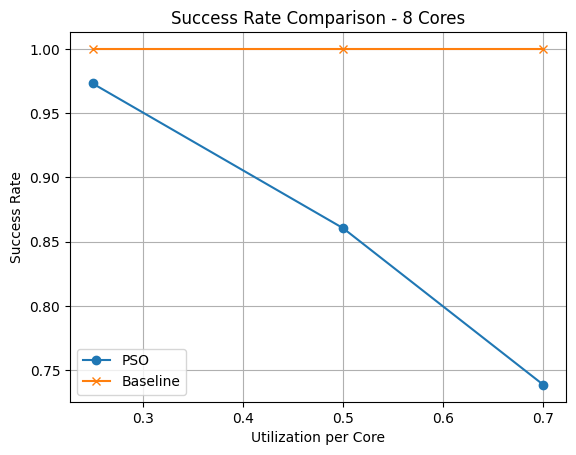


Success Rate at 0.25 Utilization (System: 8 Cores): PSO decreased by 2.69%
Success Rate at 0.5 Utilization (System: 8 Cores): PSO decreased by 13.95%
Success Rate at 0.7 Utilization (System: 8 Cores): PSO decreased by 26.15%

-------------------------------------------------------------------------------------


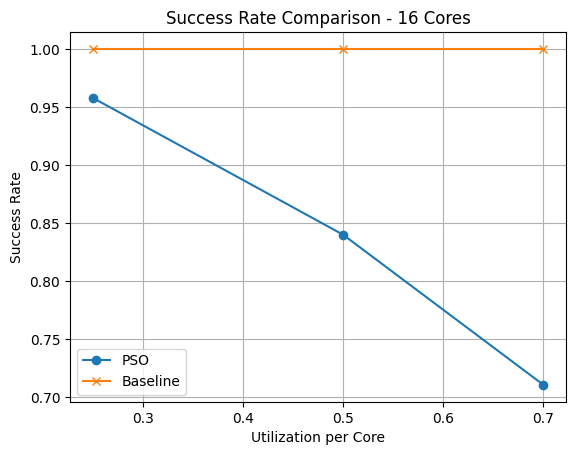


Success Rate at 0.25 Utilization (System: 16 Cores): PSO decreased by 4.21%
Success Rate at 0.5 Utilization (System: 16 Cores): PSO decreased by 16.01%
Success Rate at 0.7 Utilization (System: 16 Cores): PSO decreased by 28.96%

-------------------------------------------------------------------------------------


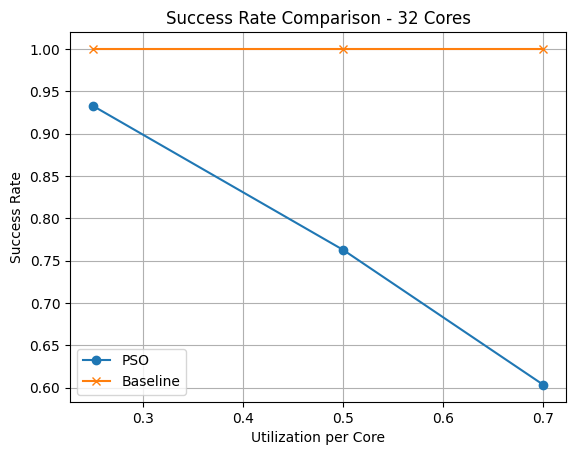


Success Rate at 0.25 Utilization (System: 32 Cores): PSO decreased by 6.70%
Success Rate at 0.5 Utilization (System: 32 Cores): PSO decreased by 23.73%
Success Rate at 0.7 Utilization (System: 32 Cores): PSO decreased by 39.68%



In [ ]:
# Energy Consumption
pso_energy_8_core = [425549, 815980, 1325929]
baseline_energy_8_core = [740550, 994900, 1496950]

pso_energy_16_core = [835239, 1682445, 2299803]
baseline_energy_16_core = [1106250, 1926600, 2750550]

pso_energy_32_core = [1586213, 3541284, 4114233]
baseline_energy_32_core = [2120500, 4629200, 5518950]

# QoS (Quality of Service)
pso_qos_8_core = [10587, 7534, 8149]
baseline_qos_8_core = [10606, 8068, 9149]

pso_qos_16_core = [9680, 6539, 6799]
baseline_qos_16_core = [9773, 7040, 7826]

pso_qos_32_core = [8783, 7513, 5927]
baseline_qos_32_core = [8929, 8674, 8215]

# Success Rate
pso_success_8_core = [0.9731266149870801, 0.8604651162790697, 0.7384535547483134]
baseline_success_8_core = [1.0, 1.0, 1.0]

pso_success_16_core = [0.9579268292682926, 0.8399034593724859, 0.7104420243433697]
baseline_success_16_core = [1.0, 1.0, 1.0]

pso_success_32_core = [0.9329774614472124, 0.7627118644067796, 0.6032078103207811]
baseline_success_32_core = [1.0, 1.0, 1.0]

utilization = [0.25, 0.5, 0.7]

def plot_comparison(pso_data, baseline_data, system_cores, metric_name, utilization):
    print('-------------------------------------------------------------------------------------')
    plt.plot(utilization, pso_data, label="PSO", marker='o')
    plt.plot(utilization, baseline_data, label="Baseline", marker='x')
    plt.xlabel('Utilization per Core')
    plt.ylabel(metric_name)
    plt.title(f'{metric_name} Comparison - {system_cores} Cores')
    plt.legend()
    plt.grid(True)
    plt.show()

    print()
    for i in range(len(utilization)):
        pso_value = pso_data[i]
        baseline_value = baseline_data[i]
        if baseline_value != 0:
            percentage_decrease = ((baseline_value - pso_value) / baseline_value) * 100
        else:
            percentage_decrease = 0
        print(f'{metric_name} at {utilization[i]} Utilization (System: {system_cores} Cores): PSO decreased by {percentage_decrease:.2f}%')
    print()

for system_cores, pso_energy, baseline_energy in zip([8, 16, 32],
                                                     [pso_energy_8_core, pso_energy_16_core, pso_energy_32_core],
                                                     [baseline_energy_8_core, baseline_energy_16_core, baseline_energy_32_core]):
    plot_comparison(pso_energy, baseline_energy, system_cores, 'Energy Consumption', utilization)

for system_cores, pso_qos, baseline_qos in zip([8, 16, 32],
                                               [pso_qos_8_core, pso_qos_16_core, pso_qos_32_core],
                                               [baseline_qos_8_core, baseline_qos_16_core, baseline_qos_32_core]):
    plot_comparison(pso_qos, baseline_qos, system_cores, 'QoS', utilization)

for system_cores, pso_success, baseline_success in zip([8, 16, 32],
                                                       [pso_success_8_core, pso_success_16_core, pso_success_32_core],
                                                       [baseline_success_8_core, baseline_success_16_core, baseline_success_32_core]):
    plot_comparison(pso_success, baseline_success, system_cores, 'Success Rate', utilization)